In [1]:
# import packages

import os, sys
import gymnasium as gym
import time
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from collections import defaultdict
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import text_flappy_bird_gym



# 1. Monte Carlo Control

First initialize the TextFlappyBird environment.

In [62]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset() 

((13, -4), {'score': 0, 'player': [6, 7], 'distance': 13.601470508735444})

MC Control involves updating the Q-value after each completion of a whole episode. This is an on-policy method, where we use an epsilon-greedy policy (converging to a greedy stragey).

First, we create some helper functions, in order to : 
- Generate a whole episode, given a Q-table
- Update the Q-table based on collected rewards

In [192]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ 
    env : environment
    Q : action value function
    epsilon : proba of random policy
    nA : nber of actions
    """
    episode = []
    state = env.reset()[0]
    while True:
        # draw action following the distribution computed by get_probs, which is equivalent to an epsilon greedy policy
        action = np.random.choice(np.arange(nA), p=get_probs_eps_greedy(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode, info["score"]


def argmax(q_values):
        """argmax with random tie-breaking
        """
        ties = np.where(q_values == np.max(q_values))[0]
        return np.random.choice(ties)

def get_probs_eps_greedy(Q_s, epsilon, nA):
    """ Obtains the action probabilities corresponding to an epsilon-greedy policy 
    
    Q_s : array containing action-value functions for this state
    epsilon : proba of random policy
    nA : nber of actions

    Returns : 
    policy_s : dictionary where policy[s] returns the action that the agent chooses after observing state s
    
    """
    policy_s = np.ones(nA) * epsilon/(nA - 1) # proba of taking any action apart from the best one : epsilon / (nA - 1)
    best_a = argmax(Q_s)
    policy_s[best_a] = 1 - epsilon # proba of taking the greedy action : 1 - epsilon
    # so that sum of all probas is 1 - epsilon + (nA - 1)*epsilon/(nA - 1) = 1
    return policy_s # each entry gives the probability of taking action a if we follow an epsilon greedy policy

def update_Q(episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode) # loop for each step of episode
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        # compute the discounted return at i (MC update!)
        G_i = sum(discounts[:-(i+1)] * rewards[i:])
        Q[state][actions[i]] = old_Q + alpha*(G_i - old_Q)
    return Q

Next, we write a function for the training procedure :

In [193]:
# [Graded]
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1, eps_decay=.99999, eps_min=0.05):
    start = time.time()
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    return_list = []
    score_list = []

    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode, score = generate_episode_from_Q(env, Q, epsilon, nA)
        score_list.append(score)
        # add total return of generated episode to the list
        _, _, rewards = zip(*episode)
        return_list.append(sum(rewards))
        # update the action-value function estimate using the episode
        Q = update_Q(episode, Q, alpha, gamma)
    end = time.time()
    print(f"Duration of training : {end-start}")
    
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,argmax(v)) for k, v in Q.items())
    
    return policy, Q, return_list, score_list

In [194]:
# obtain the estimated optimal policy and action-value function
policy_mc, Q_mc, return_list_mc, score_list_mc = mc_control(env, 400000, 0.02)


Episode 400000/400000.Duration of training : 1240.2798392772675


Plot the state value function :

In [248]:
policy_table_mc = np.zeros((14,24)) - 1
for k in policy_mc.keys():
    policy_table_mc[k[0], k[1] + 12] = policy_mc[k]

Text(0.5, 1.0, 'Policy - Monte Carlo Control')

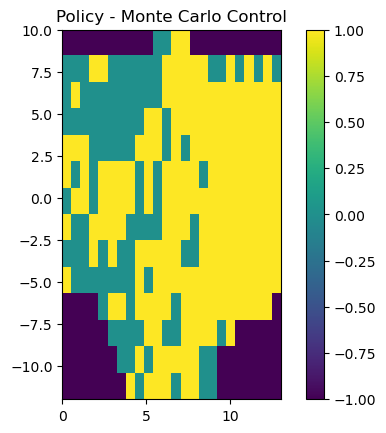

In [259]:
plt.imshow(policy_table_mc, extent = [0, 13, -12, 10])
plt.colorbar()
plt.title("Policy - Monte Carlo Control")

The 1 value denotes the action "Flap".   
The 0 value denotes the action "Idle".   
The -1 value means that the state was not explored during training; if the agent gets into this state, it will take a random action. 

Let's print one game played following the learned policy :

In [261]:
obs = env.reset()[0]
n_steps = 0
# iterate
while True:

    # Select next action
    action = policy_mc[obs]

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done or n_steps == 200:
        break
    n_steps += 1

env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=4)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=6)
Text Flappy Bird!
Score: 0
----------------------
[       

# 2. Q-Learning

We now implement a Q-Learning strategy. It is an off-policy method, where we optimize the action-value function independently of the policy followed to choose the actions. The actions are chosen using an epsilon greedy policy, in order to ensure a trade-off between exploiration and exploration. Q-table updates are performaed using a greedy policy.

In [271]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset() 

def initialize_q_table(state_space_dim1, state_space_dim2, action_space):
    np.random.seed(seed=29)
    Qtable = np.random.rand(state_space_dim1, state_space_dim2, action_space)
    return Qtable

def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0,1)
    if random_int > epsilon:
        action = argmax(Qtable[state])
    else:
        action = env.action_space.sample()
    return action

def greedy_policy(Qtable, state):
    action = argmax(Qtable[state])
    return action

def train(n_training_episodes, env, Qtable, gamma=1, eps_start=1, eps_min=0.05, eps_decay=0.99999, learning_rate=0.02):
    start = time.time()
    epsilon = eps_start
    return_list = []
    score_list = []
    for episode in tqdm(range(n_training_episodes)):
        rewards = []

        # the epsilon is updated at each new episode
        epsilon = np.max([epsilon*eps_decay, eps_min])

        # Reset the environment
        state = env.reset()[0]
        step = 0
        done = False

        while True:

            # the action is based on an epsilon greedy policy, based on current state and actual estimation of Qtable
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # we observe the new state and the reward
            # env.step(a) -> obs, reward, done, False, info
            new_state, reward, done, _, info = env.step(action)
            rewards.append(reward)

            # update the Qtable based on greedy policy !
            # indeed the estimated value of the next state is the maximal value of all actions of new_state
            Qtable[state[0]][state[1]][action] = Qtable[state[0]][state[1]][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state[0]][new_state[1]]) - Qtable[state[0]][state[1]][action])

            # If done, finish the episode
            if done:
                # not discounted, we want the sum of rewards to be as high as possible
                G = sum(rewards)
                return_list.append(G)
                score_list.append(info["score"])
                break
            
            # Our state is the new state
            state = new_state

    end = time.time()
    print(f"Duration of training : {end-start}")
    policy = dict()
    for x in range(env.observation_space[0].n):
        for y in range(env.observation_space[1].n):
            policy[(x,y-12)] = argmax(Qtable[x, y, :])
    return policy, Qtable, return_list, score_list

In [272]:
# Training parameters
n_training_episodes = 400000
alpha = 0.02         
gamma = 1

Qtable_init = initialize_q_table(env.observation_space[0].n, env.observation_space[1].n, env.action_space.n)
policy_qlearning, Qtable_qlearning, return_list_q, score_list_q = train(n_training_episodes, env, Qtable_init, learning_rate=alpha)

100%|██████████| 400000/400000 [55:02<00:00, 121.11it/s] 

Duration of training : 3302.6860630512238


Text(0.5, 1.0, 'Policy - Q-Learning')

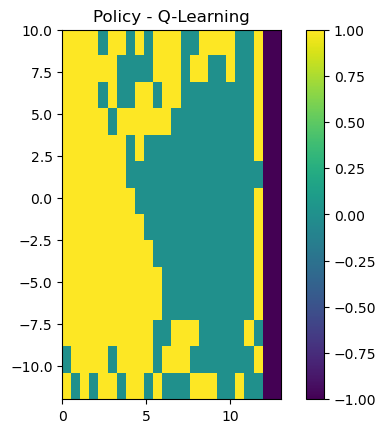

In [279]:
policy_table_q = np.zeros((14,24)) - 1
for k in policy_qlearning.keys():
    policy_table_q[k[0], k[1] + 12] = policy_qlearning[k]

plt.imshow(policy_table_q, extent = [0, 13, -12, 10])
plt.colorbar()
plt.title("Policy - Q-Learning")

1 = Flap ; 0 = Idle ; -1 = Not explored